In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd

src_path = Path(
    "/Users/pszyc/Library/CloudStorage/GoogleDrive-przemek.7678@gmail.com/My Drive/Studia/Ogniska/"
)

data_files = list(src_path.rglob("00*"))

data_files = [path for path in data_files if (path / "nuclei_mask.npy").exists()]
print(len(data_files))

676


In [ ]:
90.0 um 67.2 um

15 lm xyz (1392  1040  50 px)

# Run

In [24]:
from tqdm import tqdm
import numpy as np
import pandas as pd

rows = []

for data_selected in tqdm(data_files):
    image_info = "/".join(str(data_selected).split("/")[-3:])
    mask_path = data_selected / "nuclei_mask.npy"

    # memory-map avoids loading full copy into RAM
    mask = np.load(mask_path, mmap_mode="r")

    # FAST for integer labels (typical segmentation masks)
    counts = np.bincount(mask.ravel())
    labels = np.flatnonzero(counts)      # labels that exist
    vals = counts[labels]

    # skip background label 0 if needed
    keep = labels != 0
    labels = labels[keep]
    vals = vals[keep]

    rows.extend(
        {"image_info": image_info, "label": int(l), "count": int(c)}
        for l, c in zip(labels, vals)
    )

counts_df = pd.DataFrame(rows).sort_values(["image_info", "label"]).reset_index(drop=True)

100%|██████████| 676/676 [1:13:03<00:00,  6.48s/it]


In [27]:
counts_df.to_csv("nuclei_mask_counts.csv")

# Analyze

In [60]:
counts_df = pd.read_csv("nuclei_mask_counts.csv")
counts_df['vol'] = counts_df['count'] * 0.065 * 0.065 * 0.3
counts_df['x'] = np.cbrt(counts_df['vol'])

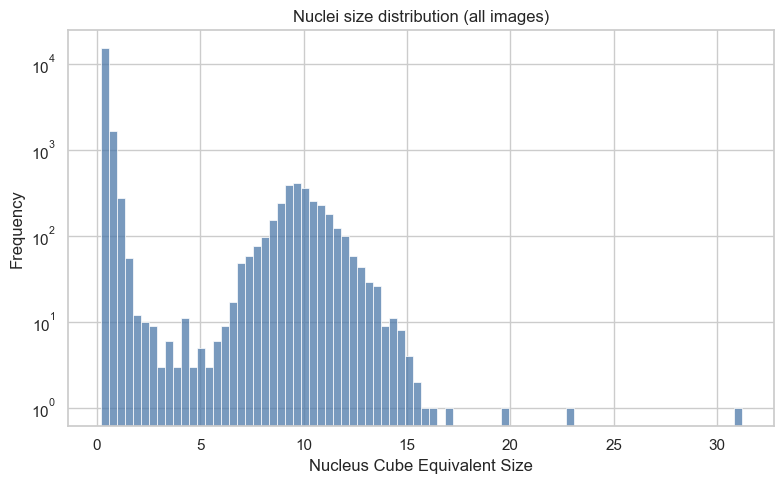

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 5))
sns.histplot(data=counts_df, x='x', bins=80, kde=False, color="#4C78A8")
plt.title("Nuclei size distribution (all images)")
plt.xlabel("Nucleus Cube Equivalent Size")
plt.ylabel("Frequency")
plt.yscale("log")  # log count axis
plt.tight_layout()
plt.show()

In [67]:
counts_df = counts_df[(counts_df['x'] >= 4) & (counts_df['x'] <= 18)]

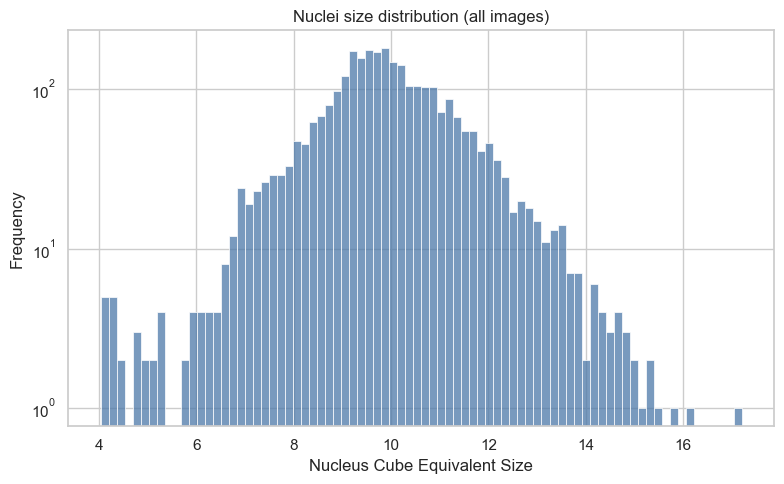

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 5))
sns.histplot(data=counts_df, x='x', bins=80, kde=False, color="#4C78A8")
plt.title("Nuclei size distribution (all images)")
plt.xlabel("Nucleus Cube Equivalent Size")
plt.ylabel("Frequency")
plt.yscale("log")  # log count axis
plt.tight_layout()
plt.show()

In [69]:
cell_line = counts_df['image_info'].apply(lambda x: x.split("_")[0])
cell_line.value_counts()

image_info
U87     1754
NHDF    1213
Name: count, dtype: int64

In [70]:
counts_df['image_info'].nunique()

676

In [71]:
len(counts_df) / counts_df['image_info'].nunique()

4.3890532544378695